In [1]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import os
import numpy as np
import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

In [2]:
top_down_path = os.getcwd()
os.chdir("../Data")
data_path = os.getcwd()
os.chdir(top_down_path)

# Read data

In [3]:
# Read preprocessed
df = pd.read_csv(os.path.join(data_path, "preprocessed.csv"), index_col=0)
df.index = pd.to_datetime(df.index)

<AxesSubplot:>

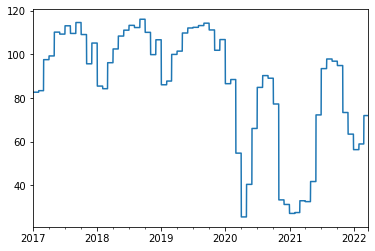

In [4]:
df['hospitality_sector'].plot()

# Prepare regression data

In [5]:
dfx = df.copy()
dfx = dfx.rename(columns={
    'aggregated': 'w2h',
    'electricity_from_gas': 'power',
    'producing_sector': 'prod',
    'manufacturing_sector': 'manu',
    'retail_sector': 'retail',
    'hospitality_sector': 'hosp',
    'gas_price [€/MWh]': 'prices'
})

dfx['log_slp'] = np.log(dfx['slp'])
dfx['log_rlm'] = np.log(dfx['rlm'])
dfx['power2'] = dfx['power'].apply(lambda x: x**2)

dfx = dfx[
    (dfx.holiday==0) & 
    (dfx.christmas_period==0) & 
    (dfx.bridgeday==0)
]

# Cut corona
# covid_beginning = "2020-02-01" --> lockdown started on 13 March 2020
#dfx = dfx[(dfx.index < '2020-03-01')|(dfx.index >= '2021-05-01')]

In [6]:
crisis_start = "2021-09-01"
fitting_start = "2017-09-01"
# invasion_date = "2022-02-24"

Monthly treatment dummies from Sep 2021 onwards:

In [7]:
def model(dummy_list, consumer='rlm', further_controls=False):
    
    dfx['crisis'] = dfx.index.map(lambda x: x >= crisis_start)
    
    results = {}
    
    for name in ['naive', 'temp'] + (
        ['temp+power', 'temp+power+econ'] if consumer=='rlm' else ['temp+econ']
    ):
    
        m = f'{"log_" if log else ""}{consumer} ~ 1 + time + C(month) + C(weekday) + ' + ' + '.join(dummy_list)
        
        if further_controls:
            control_list = []
            for date in pd.date_range(fitting_start, pd.Timestamp(crisis_start) - pd.Timedelta('1y'), freq='1m'):
                dummy_name = f'm{date.year}_{date.month}'
                dfx.loc[dfx.index, dummy_name] = dfx.index.map(
                    lambda x: (x.year==date.year) & (x.month==date.month)
                ).values
                control_list.append(dummy_name)
            m += ' + ' + ' + '.join(control_list)
        
        if 'temp' in name:
            m += ' + residential + commercial'
        if 'power' in name:
            m += ' + power'
        if 'econ' in name:
            m += (' + manu' if consumer=='rlm' else ' + 1')
    
        results[name] = smf.ols(m, dfx.loc[fitting_start:]).fit(cov_type='HAC', cov_kwds={'maxlags':6})

    return results

In [8]:
def extract_results(dummy_list, results):
    
    extracted_results = pd.concat(
        [results.params, results.bse], keys=['coef', 'se'], axis=1
    )
    
    extracted_results = extracted_results*100 if log else extracted_results
    extracted_results = extracted_results.loc[[d + '[T.True]' for d in dummy_list]]
    extracted_results.index = dummy_list
    extracted_results['low'] = extracted_results['coef'] - 2 * extracted_results['se']
    extracted_results['high'] = extracted_results['coef'] + 2 * extracted_results['se']
    
    return extracted_results

In [9]:
def plot(ax, results, consumer='rlm', ylabel=''):

    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
    
    for i, (name, res) in enumerate(results.items()):
        
        # first bar
        if i==0:
            ax.bar(i, res['coef'], alpha=0.5, color=colors[i])
            ax.plot([i,i], [res['low'], res['high']], color=colors[i])
        
        # waterfall
        if i > 0:
            ax.bar(i, res['coef'] - previous_coef, bottom=previous_coef, alpha=0.5, color=colors[i])    
            ax.plot([i-1.4,i+0.4], [previous_coef, previous_coef], color='black', linewidth=0.7, linestyle='--')
            ax.plot([i-0.4,i+1.4], [res['coef'], res['coef']], color='black', linewidth=0.7, linestyle='--')
            
        previous_coef = res['coef']
    
    # last bar
    i += 1
    ax.bar(i, res['coef'], alpha=0.5, color=colors[i])
    ax.plot([i,i], [res['low'], res['high']], color=colors[i])
    
    ax.grid(axis='y')
    ax.axhline(0, color='black', linewidth=0.5)
    ax.set_ylabel(ylabel)
    ax.set_title('Small consumers' if consumer=='slp' else 'Large consumers')
    #if log:
    #    ax.set_ylim(-21, 7)
    #ax.set_xticks(
        #range(len(results)+1), 
        #['Overall', 'Temperature'] + (
            #['Power\nsector'] if consumer=='rlm' else []
        #) + ['Economic\nactivity', 'Extraordinary\nresponse']
    #)

# One crisis dummy
Log-linear model

In [10]:
def one_dummy(further_controls=False):
    
    dummy_list=['crisis']

    results = {consumer: model(dummy_list, consumer, further_controls=further_controls) for consumer in ['slp', 'rlm']}
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,4.5), sharey='row', gridspec_kw={'width_ratios': [1.2,2]})

    res = {m: extract_results(dummy_list, value) for m, value in results['slp'].items()}
    ax1 = plot(ax1, res, 'slp', 'Estimated change in demand ' + ('(%)' if log else '(TWh/d)'))

    res = {m: extract_results(dummy_list, value) for m, value in results['rlm'].items()}
    ax2 = plot(ax2, res, 'rlm')

    plt.tight_layout()
    plt.savefig(f'one_dummy{"_log" if log else ""}.png', dpi=300)
    
    return results

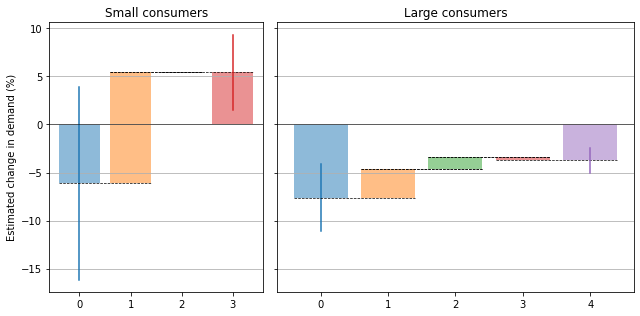

In [11]:
log=True
fitting_start = "2017-01-01"
crisis_start = "2021-09-01"
results_log = one_dummy()

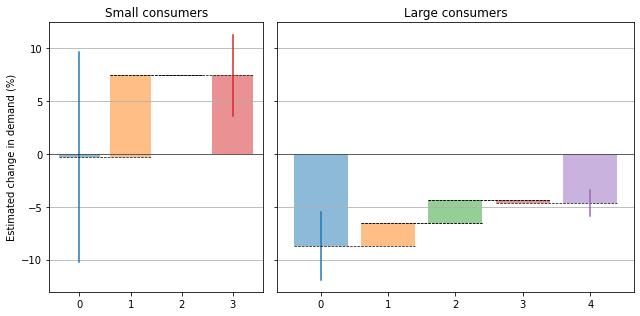

In [12]:
log=True
fitting_start = "2017-01-01"
crisis_start = "2021-08-01"
results_log = one_dummy()

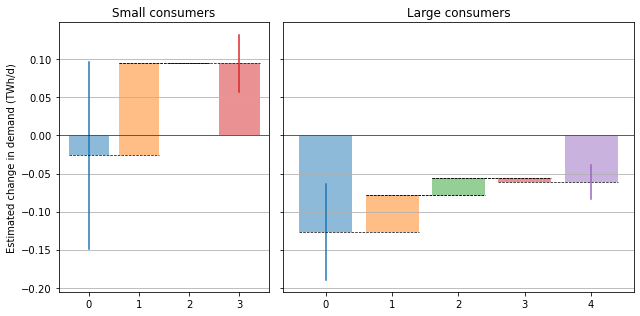

In [13]:
log=False
fitting_start = "2017-01-01"
crisis_start = "2021-09-01"
results = one_dummy()

# secondary axis (% of ind. demand)
# 366 TWh/y -> https://gas.info/fileadmin/Public/PDF-Download/Faktenblatt-Erdgas.pdf

# control for slp economic activity ()

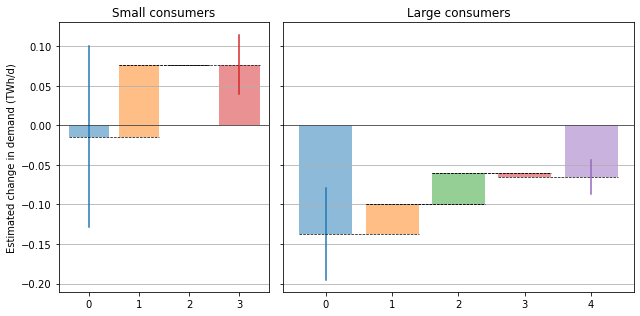

In [14]:
log=False
fitting_start = "2017-01-01"
crisis_start = "2021-08-01"
results = one_dummy()

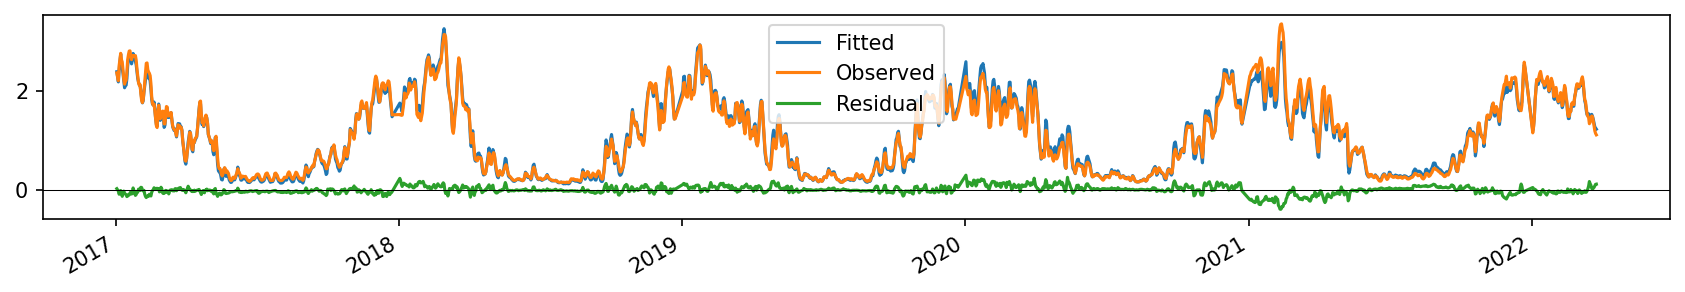

In [39]:
resid = results['slp']['temp+econ'].fittedvalues - dfx['slp'] 

plt.figure(figsize=(14, 2), dpi=150)
results['slp']['temp+econ'].fittedvalues.plot(label='Fitted')
dfx['slp'].plot(label='Observed')
resid.plot(label='Residual')
plt.axhline(0, color='black', linewidth=0.5)
plt.legend()

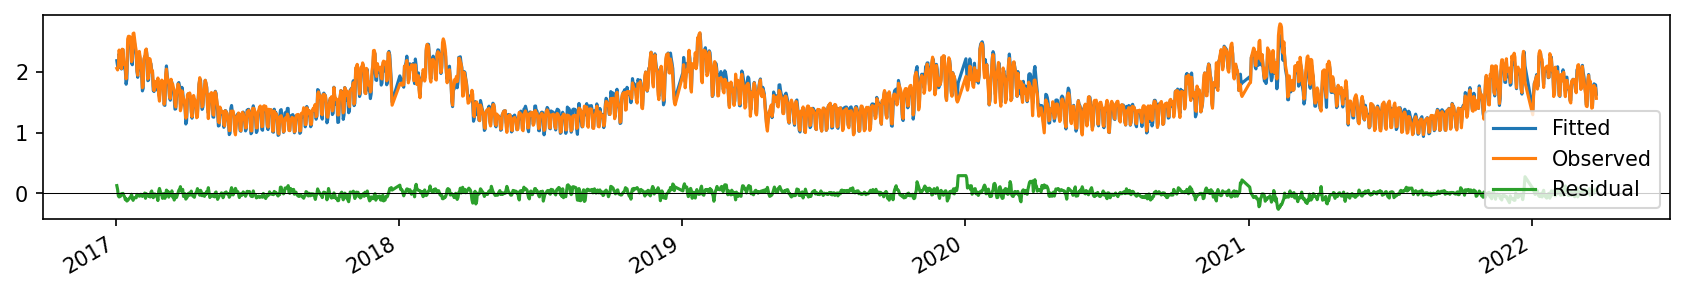

In [38]:
resid = results['rlm']['temp+power+econ'].fittedvalues - dfx['rlm'] 

plt.figure(figsize=(14, 2), dpi=150)
results['rlm']['temp+power+econ'].fittedvalues.plot(label='Fitted')
dfx['rlm'].plot(label='Observed')
resid.plot(label='Residual')
plt.axhline(0, color='black', linewidth=0.5)
plt.legend()

# Further controls

C:\Users\C3250~1.STI\AppData\Local\Temp/ipykernel_16456/1395684815.py:5: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  results = {consumer: model(dummy_list, consumer, further_controls=further_controls) for consumer in ['slp', 'rlm']}
C:\Users\C3250~1.STI\AppData\Local\Temp/ipykernel_16456/1395684815.py:5: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  results = {consumer: model(dummy_list, consumer, further_controls=further_controls) for consumer in ['slp', 'rlm']}
C:\Users\C3250~1.STI\AppData\Local\Temp/ipykernel_16456/1395684815.py:5: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  results = {consumer: model(dummy_list, consumer, further_controls=further_controls) for consumer in ['slp', 'rlm']}
C:\Users\C3250~1.STI\AppData\Local\Temp/ipykernel_16456

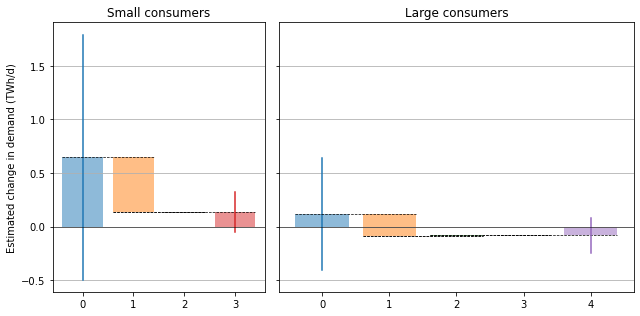

In [17]:
log=False
fitting_start = "2017-01-01"
crisis_start = "2021-08-01"
results_fc = one_dummy(further_controls=True)

In [18]:
results['rlm']['temp'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    rlm   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     577.4
Date:                Thu, 23 Jun 2022   Prob (F-statistic):               0.00
Time:                        14:14:57   Log-Likelihood:                 1724.2
No. Observations:                1764   AIC:                            -3404.
Df Residuals:                    1742   BIC:                            -3284.
Df Model:                          21                                         
Covariance Type:                  HAC                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   1.3270      0.044     29.900      0.000       1.240       1.414
C(month)[T.2]              -0.0389      0.023     -1.658      0.097      -0.085       0.007
C(month)[T.3]              -0.1189      0.027     -4.414      0.000      -0.172      -0.066
C(month)[T.4]              -0.1824      0.031     -5.876      0.000      -0.243      -0.122
C(month)[T.5]              -0.1872      0.029     -6.450      0.000      -0.244      -0.130
C(month)[T.6]              -0.1381      0.032     -4.258      0.000      -0.202      -0.075
C(month)[T.7]              -0.1383      0.034     -4.084      0.000      -0.205      -0.072
C(month)[T.8]              -0.1619      0.033     -4.875      0.000      -0.227      -0.097
C(month)[T.9]              -0.1099      0.031     -3.519      0.000      -0.171      -0.049
C(month)[T.10]             -0.0639      0.027     -2.335      0.020      -0.117      -0.010
C(month)[T.11]             -0.0098      0.022     -0.437      0.662      -0.054       0.034
C(month)[T.12]             -0.0297      0.025     -1.193      0.233      -0.078       0.019
C(weekday)[T.Monday]        0.0514      0.006      7.933      0.000       0.039       0.064
C(weekday)[T.Saturday]     -0.2271      0.007    -33.994      0.000      -0.240      -0.214
C(weekday)[T.Sunday]       -0.2309      0.007    -32.400      0.000      -0.245      -0.217
C(weekday)[T.Thursday]      0.0619      0.005     11.348      0.000       0.051       0.073
C(weekday)[T.Tuesday]       0.0663      0.007      9.588      0.000       0.053       0.080
C(weekday)[T.Wednesday]     0.0660      0.007     10.080      0.000       0.053       0.079
crisis[T.True]             -0.0992      0.017     -5.736      0.000      -0.133      -0.065
time                     5.442e-05   1.05e-05      5.203      0.000    3.39e-05    7.49e-05
residential                 0.1429      0.134      1.063      0.288      -0.121       0.406
commercial                  1.0344      0.263      3.937      0.000       0.519       1.549
==============================================================================
Omnibus:                      115.657   Durbin-Watson:                   0.505
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              302.658
Skew:                          -0.356   Prob(JB):                     1.90e-66
Kurtosis:                       4.900   Cond. No.                     9.28e+04
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 6 lags and without small sample correction
[2] The condition number is large, 9.28e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [19]:
df['rlm'].mean()

1.61099867681466

# Quarterly dummies

In [20]:
mode = 'quarterly'
dummy_list = []
for date in pd.date_range(crisis_start, '2022-04', freq='3m'):
    dummy_name = f'd{date.year}_{date.quarter}'
    dfx.loc[dfx.index, dummy_name] = dfx.index.map(
        lambda x: (x.year==date.year) & (x.quarter==date.quarter)
    ).values
    dummy_list.append(dummy_name)

In [21]:
mode = 'monthly'
dummy_list = []
for date in pd.date_range(crisis_start, '2022-04', freq='1m'):
    dummy_name = f'd{date.year}_{date.month}'
    dfx.loc[dfx.index, dummy_name] = dfx.index.map(
        lambda x: (x.year==date.year) & (x.month==date.month)
    ).values
    dummy_list.append(dummy_name)

## SLP

In [22]:
results_slp_log = {}
for m in ['naive', 'temp']:
    model = 'log_slp ~ 1 + time + C(month) + C(weekday) + ' + ' + '.join(dummy_list)
    if 'temp' in m:
        model += ' + residential + commercial'
    results_slp_log[m] = smf.ols(model, dfx.loc[fitting_start:]).fit(cov_type='HAC', cov_kwds={'maxlags':6})

results_slp_log['temp'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_slp   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     1213.
Date:                Thu, 23 Jun 2022   Prob (F-statistic):               0.00
Time:                        14:14:57   Log-Likelihood:                 1219.5
No. Observations:                1764   AIC:                            -2381.
Df Residuals:                    1735   BIC:                            -2222.
Df Model:                          28                                         
Covariance Type:                  HAC                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -1.6326      0.093    -17.564      0.000      -1.815      -1.450
C(month)[T.2]               0.0157      0.032      0.490      0.624      -0.047       0.078
C(month)[T.3]               0.0393      0.027      1.440      0.150      -0.014       0.093
C(month)[T.4]              -0.0567      0.038     -1.496      0.135      -0.131       0.018
C(month)[T.5]              -0.2145      0.052     -4.158      0.000      -0.316      -0.113
C(month)[T.6]              -0.4953      0.061     -8.142      0.000      -0.615      -0.376
C(month)[T.7]              -0.5435      0.062     -8.726      0.000      -0.666      -0.421
C(month)[T.8]              -0.5904      0.065     -9.025      0.000      -0.719      -0.462
C(month)[T.9]              -0.3507      0.052     -6.767      0.000      -0.452      -0.249
C(month)[T.10]             -0.1308      0.037     -3.576      0.000      -0.202      -0.059
C(month)[T.11]             -0.0022      0.023     -0.095      0.924      -0.047       0.043
C(month)[T.12]              0.0238      0.020      1.190      0.234      -0.015       0.063
C(weekday)[T.Monday]        0.0378      0.007      5.674      0.000       0.025       0.051
C(weekday)[T.Saturday]     -0.1462      0.010    -14.740      0.000      -0.166      -0.127
C(weekday)[T.Sunday]       -0.1315      0.010    -13.101      0.000      -0.151      -0.112
C(weekday)[T.Thursday]      0.0422      0.005      7.838      0.000       0.032       0.053
C(weekday)[T.Tuesday]       0.0409      0.006      6.371      0.000       0.028       0.054
C(weekday)[T.Wednesday]     0.0202      0.006      3.532      0.000       0.009       0.031
d2021_8[T.True]             0.1457      0.036      4.013      0.000       0.075       0.217
d2021_9[T.True]             0.0416      0.048      0.866      0.386      -0.052       0.136
d2021_10[T.True]            0.1356      0.033      4.134      0.000       0.071       0.200
d2021_11[T.True]            0.0800      0.025      3.196      0.001       0.031       0.129
d2021_12[T.True]           -0.0104      0.034     -0.303      0.762      -0.077       0.057
d2022_1[T.True]             0.0465      0.032      1.472      0.141      -0.015       0.108
d2022_2[T.True]             0.1138      0.035      3.233      0.001       0.045       0.183
d2022_3[T.True]             0.0021      0.034      0.063      0.950      -0.064       0.068
time                     7.937e-05   1.46e-05      5.425      0.000    5.07e-05       0.000
residential                 4.5869      0.269     17.033      0.000       4.059       5.115
commercial                 -6.2221      0.475    -13.103      0.000      -7.153      -5.291
==============================================================================
Omnibus:                      193.300   Durbin-Watson:      

In [23]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple']

if mode=='monthly':
    plt.figure(figsize=(8,4))

for i, m in enumerate(['naive', 'temp']):
    
    extracted_results = extract_results(results_slp_log[m], dummy_list=dummy_list)
    
    idx = [j-0.3+0.2*i for j in range(len(extracted_results))]
    plt.bar(idx, extracted_results['coef'], width=0.2,alpha=0.5, label=m)
    for j, d in enumerate(dummy_list):
        plt.plot([idx[j],idx[j]], [extracted_results.loc[d, 'low'], extracted_results.loc[d, 'high']], 
                 color=colors[i])
        
for i in range(len(extracted_results)-1):
    plt.axvline(i+0.5, color='black', linewidth=0.5)

plt.grid(axis='y')
plt.axhline(0, color='black', linewidth=0.5)
plt.ylabel('Estimated demand reduction (%)')
plt.title('Small consumers')
plt.ylim(-25, 50)
if mode=='monthly':
    plt.xticks(range(len(extracted_results)), 
               [f'{date.month_name()[:3]}'+(f'\n{date.year}' if date.month==1 else '')
                for date in pd.date_range('2021-01', '2022-04', freq='1m')])    
else:
    plt.xticks(range(len(extracted_results)), 
               [f'Q{date.quarter}'+(f'\n{date.year}' if date.quarter==1 else '')
                for date in pd.date_range('2021-01', '2022-04', freq='3m')])    
plt.legend(loc='lower right')
plt.savefig('slp_quarterly.png', dpi=300)

TypeError: extract_results() got multiple values for argument 'dummy_list'

<Figure size 576x288 with 0 Axes>

In [ ]:
dfx['log_slp'] = np.log(dfx['slp'])

model = 'log_slp ~ 1 + w2h + time + C(month) + C(weekday) + ' + ' + '.join(dummy_list)
results_slp_log = smf.ols(model, dfx.loc[fitting_start:]).fit(cov_type='HAC', cov_kwds={'maxlags':6})

results_slp_log.summary()

In [ ]:
extracted_results = extract_results(results_slp_log, dummy_list=dummy_list)
ax = extracted_results['coef'].plot(kind='bar',alpha=0.5)
for d in dummy_list:
    plt.plot([d,d], [extracted_results.loc[d, 'low'], extracted_results.loc[d, 'high']], color='tab:blue')
    
plt.grid(axis='y')
plt.axhline(0, color='black', linewidth=0.5)
plt.ylabel('Estimated demand reduction (%)')
plt.title('SLP')
plt.ylim(-5, 25)

## RLM

In [ ]:
dfx['log_rlm'] = np.log(dfx['rlm'])

results_rlm_log = {}
for m in ['naive', 'temp', 'temp+power', 'temp+power+econ']:
    model = 'log_rlm ~ 1 + time + C(month) + C(weekday) + ' + ' + '.join(dummy_list)
    if 'temp' in m:
        model += ' + residential + commercial'
    if 'power' in m:
        model += ' + power'
    if 'econ' in m:
        model += ' + manu'
    results_rlm_log[m] = smf.ols(model, dfx.loc[fitting_start:]).fit(cov_type='HAC', cov_kwds={'maxlags':6})

results_rlm_log['temp+power+econ'].summary()

In [ ]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple']

if mode=='monthly':
    plt.figure(figsize=(8,4))

for i, m in enumerate(['naive', 'temp', 'temp+power', 'temp+power+econ']):
    
    extracted_results = extract_results(results_rlm_log[m], dummy_list=dummy_list)
    
    idx = [j-0.3+0.2*i for j in range(len(extracted_results))]
    plt.bar(idx, extracted_results['coef'], width=0.2,alpha=0.5, label=m)
    for j, d in enumerate(dummy_list):
        plt.plot([idx[j],idx[j]], [extracted_results.loc[d, 'low'], extracted_results.loc[d, 'high']], 
                 color=colors[i])
        
for i in range(len(extracted_results)-1):
    plt.axvline(i+0.5, color='black', linewidth=0.5)

plt.grid(axis='y')
plt.axhline(0, color='black', linewidth=0.5)
plt.ylabel('Estimated demand reduction (%)')
plt.title('Large consumers')
plt.ylim(-20, 25)
if mode=='monthly':
    plt.xticks(range(len(extracted_results)), 
               [f'{date.month_name()[:3]}'+(f'\n{date.year}' if date.month==1 else '')
                for date in pd.date_range('2021-01', '2022-04', freq='1m')])    
else:
    plt.xticks(range(len(extracted_results)), 
               [f'Q{date.quarter}'+(f'\n{date.year}' if date.quarter==1 else '')
                for date in pd.date_range('2021-01', '2022-04', freq='3m')])    
plt.legend(loc='lower right')
plt.savefig('rlm_log.png', dpi=300)

# Linear models
SLP

In [ ]:
model = 'slp ~ 1 + w2h + time + C(month) + C(weekday) + ' + ' + '.join(dummy_list)
results_slp = smf.ols(model, dfx.loc[fitting_start:]).fit(cov_type='HAC', cov_kwds={'maxlags':6})

results_slp.summary()

In [ ]:
extracted_results = extract_results(results_slp, log=False)
ax = extracted_results['coef'].plot(kind='bar',alpha=0.5)
for d in dummy_list:
    plt.plot([d,d], [extracted_results.loc[d, 'low'], extracted_results.loc[d, 'high']], color='tab:blue')
    
plt.grid(axis='y')
plt.axhline(0, color='black', linewidth=0.5)
plt.ylabel('Estimated demand reduction (TWh/d)')
plt.title('SLP')
plt.ylim(-0.05, 0.7)

RLM

In [ ]:
results_rlm = {}
for m in ['naive', 'temp', 'temp+power', 'temp+power+econ']:
    model = 'rlm ~ 1 + time + C(month) + C(weekday) + ' + ' + '.join(dummy_list)
    if 'temp' in m:
        model += ' + w2h'
    if 'power' in m:
        model += ' + power + power2 '
    if 'econ' in m:
        model += ' + econ'
    results_rlm[m] = smf.ols(model, dfx.loc[fitting_start:]).fit(cov_type='HAC', cov_kwds={'maxlags':6})

results_rlm['temp'].summary()

In [ ]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple']

for i, m in enumerate(['naive', 'temp', 'temp+power', 'temp+power+econ']):
    
    extracted_results = extract_results(results_rlm[m], log=False)
    
    idx = [j-0.2+0.2*i for j in range(len(extracted_results))]
    plt.bar(idx, extracted_results['coef'], width=0.2,alpha=0.5, label=m)
    for j, d in enumerate(dummy_list):
        plt.plot([idx[j],idx[j]], [extracted_results.loc[d, 'low'], extracted_results.loc[d, 'high']], 
                 color=colors[i])
        
for i in range(len(extracted_results)-1):
    plt.axvline(i+0.5, color='black', linewidth=0.5)

plt.grid(axis='y')
plt.axhline(0, color='black', linewidth=0.5)
plt.ylabel('Estimated demand reduction (TWh/d)')
plt.title('RLM')
plt.ylim(-0.25, 0.15)
plt.xticks(range(len(extracted_results)), 
           [f'Q{date.quarter}'+(f'\n{date.year}' if date.quarter==1 else '')
            for date in pd.date_range('2021-01', '2022-04', freq='3m')])    
plt.legend(loc='lower right')
plt.savefig('rlm.png', dpi=300)

# Disaggregation based on fundamental assumption / energy balances

In [ ]:
plt.figure(figsize=(10,5))

#weekly
dft = df.resample("1w").mean().dropna()
plt.xlim(dft.index[[0, -1]])

upper=dft['slp']
plt.plot(dft.index, dft['slp'], label='THE SLP', color="k")

for sector, h in [
    ("residential", ""), 
    ("commercial",  "\\\\"), 
    ("decentral_chp", "..."),
    ("industry_buildings", "XX")
]:
    plt.fill_between(
        dft.index, upper-dft[sector], upper, label=sector,
        color="tab:orange", hatch=h, edgecolor="k", alpha=0.5)
    upper = upper-dft[sector]

plt.plot(upper.index, upper, color="red", label="residual_SLP")

plt.ylim(-0.2, 3)
plt.axvline(pd.Timestamp('2022-01-01'), color='black', linewidth=0.7)
plt.grid()
plt.legend(loc='center right', bbox_to_anchor=(1.21, 0.5))
plt.ylabel('Gas consumption (TWh/d)')

X = plt.gca().xaxis
X.set_major_locator(mdates.MonthLocator())
X.set_major_formatter(mdates.DateFormatter('%b'))

In [ ]:
plt.figure(figsize=(10,5))

dft= df.resample("1w").mean()
the_rlm = dft['rlm']
the_rlm.plot(label='THE RLM', color="k")

power_res = the_rlm - dft['gas_to_electricity']
industry = dft["industry_buildings"]

upper=the_rlm
for sector, c, label in [
    (industry,"tab:red","industry_buildings"), 
    (dft['gas_to_electricity'],  "tab:green", "power sector")
    # (dft["scaled_district_heat"], "tab:orange", "dist_heat")
]: 
    plt.fill_between(dft.index, upper-sector, upper , color="{}".format(c), alpha=0.3, label=label)
    upper = upper-sector 

upper.plot(color="red", label="residual_RLM")

plt.xlim(power_res.dropna().index[[0, -1]])
plt.ylim(0, 3.8)
#plt.axvline('2022-01-01', color='black', linewidth=0.7)
plt.grid()
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 0.5))
plt.ylabel('Gas consumption (TWh/d)')

plt.show()

In [ ]:
df_x_no_holiday = dfx[(dfx.holiday==0) & (dfx.christmas_period==0) & (dfx.bridgeday==0)]

In [ ]:
#SLP
model_the_slp = smf.ols(
    'slp ~ 1 + w2h + C(weekday) + C(month)', 
    data=dfx.loc[(dfx.index <= high_gas_date)&(dfx.index >= '2016-10-01')]
)
results_the_slp = model_the_slp.fit(cov_type='HAC', cov_kwds={'maxlags':6}) 
#results_the_slp.summary()



In [ ]:
the_slp_prediction = results_the_slp.predict(df_x_no_holiday[df_x_no_holiday.index.year>=2021])
the_slp_prediction.name = "the_slp_forecast"

the_slp_combined = pd.concat([
    the_slp_prediction, df_x_no_holiday.loc[df_x_no_holiday.index.year>=2021]["slp"]
], axis=1, keys=["predicted", "reported"])

the_slp_combined.resample("1w").sum().plot(ylim=0).set_ylabel("gas consumption [TWh/w]")
plt.axvline(x="2022-02-24", color='k', linestyle='--', lw=1.2)
plt.grid() 


plt.show()

delta_the_slp = the_slp_combined.iloc[:,1]-the_slp_combined.iloc[:,0]

ax = delta_the_slp.loc[delta_the_slp.index.year==2022].resample("w").sum().plot()
ax.axvline(x=invasion_date, color='k', linestyle='-.', lw=1.2 )
ax.axhline(y=0, color='k', lw=1)
plt.grid()
ax.set_xlabel("year",fontsize=14)
ax.set_ylabel("regression delta [TWh/w]", fontsize=14)




# Regression variations

## Prices

In [ ]:
model_the_prices = smf.ols('rlm ~ 1 + prices + w2h + power + econ + C(weekday)', 
                            data=df_x_no_holiday)
results_the_prices = model_the_prices.fit(cov_type='HAC', cov_kwds={'maxlags':6}) 
#results_the_prices.summary()

## Dummies

In [ ]:
dummy = pd.concat([
    pd.Series(1, index=df_x_no_holiday.index[df_x_no_holiday.index>=high_gas_date]),
    pd.Series(0, index=df_x_no_holiday.index[df_x_no_holiday.index<high_gas_date])
])

df_x_no_holiday["D"] = dummy

In [ ]:
result_dict = {
    "only_slp": {},
    "no_econ": {},
    "all": {}
}

#2020/09-2021/08 (before high gas prices)

model_rdd_only_slp = smf.ols('rlm ~ 1 +  D + w2h + C(weekday)', data=df_x_no_holiday)
results_rdd_only_slp = model_rdd_only_slp.fit(cov_type='HAC', cov_kwds={'maxlags':6})

model_rdd_no_econ = smf.ols('rlm ~ 1 + D+ w2h + power + C(weekday)', data=df_x_no_holiday)
results_rdd_no_econ = model_rdd_no_econ.fit(cov_type='HAC', cov_kwds={'maxlags':6}) 

 
model_rdd_all = smf.ols('rlm ~ 1 + D+ w2h + power + econ + C(weekday)', data=df_x_no_holiday)
results_rdd_all = model_rdd_all.fit(cov_type='HAC', cov_kwds={'maxlags':6}) 

In [ ]:
ax = pd.DataFrame(
    data=np.array([
    (results_rdd_all.params.D, results_rdd_no_econ.params.D,  results_rdd_only_slp.params.D), 
    ]), index=["10/2021 - 04/2022"], columns=["only_slp", "no_econ", "all"]
).plot(kind="bar", rot=0)
             
ax.set_ylabel("estimated reduction [%]")

In [ ]:
dummy_coefficients = pd.DataFrame(columns=["dummy_coefficients", "P_value"])

for date in pd.date_range("2020-01-01", "2022-03-01", freq="M"):
    
    dummy = pd.concat([
        pd.Series(0,index=df_x_no_holiday.index[df_x_no_holiday.index<date.strftime('%Y-%m-%d')]),
        pd.Series(1,index=df_x_no_holiday.index[df_x_no_holiday.index>=date.strftime('%Y-%m-%d')]),
    ])
    
    df_x_no_holiday["dummy"] = dummy
    
    model = 'rlm ~ 1 + dummy + w2h + time + power + econ + C(weekday)'
    results = smf.ols(model, df_x_no_holiday).fit(cov_type='HAC', cov_kwds={'maxlags':6})
    
    dummy_coefficients.loc[date.strftime('%Y-%m-%d'), "dummy_coefficients"] = results.params.dummy
    dummy_coefficients.loc[date.strftime('%Y-%m-%d'), "P_value"] = pd.read_html(results.summary().tables[1].as_html(),header=0,index_col=0)[0].loc["dummy"]["P>|z|"]

In [ ]:
dummy_coefficients.plot()
plt.grid()

### Fitting period variation

In [ ]:
#2020/09-2021/08 (before high gas prices)
model_the_20_09 = smf.ols('rlm ~ 1 + w2h + power + econ + C(weekday)', data=df_x_no_holiday.loc[
    (df_x_no_holiday.index <= high_gas_date)&(df_x_no_holiday.index >= '2020-09-01')])
results_the_20_09 = model_the_20_09.fit(cov_type='HAC', cov_kwds={'maxlags':6}) 

model_the_16_10 = smf.ols('rlm ~ 1 + w2h + power + econ + C(weekday)', data=df_x_no_holiday.loc[
    (df_x_no_holiday.index <=  high_gas_date)&(df_x_no_holiday.index >= '2016-10-01')])
results_the_16_10 = model_the_16_10.fit(cov_type='HAC', cov_kwds={'maxlags':6}) 

result_list = [
    (results_the_20_09,"fitting period: 2020/09 - 2021/08", '2020-09-01', high_gas_date),
    (results_the_16_10,"fitting period: 2016/10 - 2021/08", '2016-10-01', high_gas_date)
]

#results_the_20_09.summary()
#results_the_16_10.summary()

### Controlvariable variation

In [ ]:
#2020/09-2021/08 (before high gas prices)
result_list_2016 = []
for model_name in ["only_slp", "no_econ", "all"]:
    
    model = smf.ols(
        'rlm ~ 1 + w2h + C(weekday)' 
        + ('+ power' if model_name != 'only_slp' else '')
        + ('+ econ' if model_name == 'all' else '')
        , data=df_x_no_holiday.loc[
        (df_x_no_holiday.index <= high_gas_date)&(df_x_no_holiday.index >= '2020-10-01')]
    )
    results = model.fit() 

    result_list_2016.append((results, model_name))

In [ ]:
def prediction(df, name, start_pred, rlm=True):
    delta = pd.DataFrame()
    key_list = ["reported"]

    if rlm == True:
        rlm_slp = "rlm"
    else: 
        rlm_slp = "slp"
        
    df_pred = df.predict(df_x_no_holiday[df_x_no_holiday.index>=start_pred])
    
    df_pred.name = f"{name}_forecast"

    combined = pd.concat([
        df_pred, df_x_no_holiday.loc[df_x_no_holiday.index>=start_pred][rlm_slp]
    ], axis=1, keys=[name, "reported"])
    print(combined.loc[(combined.index >=start_pred)].mean())
    ts = (combined.iloc[:,1]-combined.iloc[:,0])
    ts.name = name 
    delta = pd.concat([delta, ts], axis=1)
    
    return combined, delta, key_list

In [ ]:
result_dict = {
    "only_slp": {},
    "no_econ": {},
    "all": {}
}

expected_amount = df_x_no_holiday.loc[df_x_no_holiday.index>=high_gas_date]["rlm"].sum()

In [ ]:
start_pred = high_gas_date

for df, name in result_list_2016:
    
    combined, delta, key_list = prediction(df, name, start_pred)
    
    result_dict[name] = (
        delta[name][delta[name].index <= high_gas_date].sum() / expected_amount
    )

In [ ]:
ax = (pd.DataFrame.from_dict(result_dict, orient="index").transpose()*100).plot(kind = "bar", rot=45, xticks=[])
ax.set_ylabel("estimated reduction [%]")



In [ ]:
for df, name, start_pred, end_pred in result_list:
    
    combined, delta, key_list = prediction(df, name, start_pred)
    
    ax = combined.loc["2020-09-01":].resample("1w").sum().plot(ylim=0, xlim=("2020-09-01", "2022-04-30"), title = name)
    ax.axvline(x="2022-02-24", color='k', linestyle='--', lw=1.2 )
    ax.axvline(x="2021-08-31", color='k', linestyle='-.', lw=1.2 )
    
    ax.text((pd.to_datetime(high_gas_date)-pd.Timedelta(18, "days")).strftime('%Y-%m-%d'), 0.8, "gas prices" +"\n"+"\n" + "> 50€/MWh", size=10, rotation=90)
    ax.text((pd.to_datetime(invasion_date)-pd.Timedelta(30, "days")).strftime('%Y-%m-%d'), 0.8, "gas prices > 100€/MWh" + "\n" +"\n" + "invasion of Ukraine", size=10, rotation=90)
    
    fit = ax.text(
        (pd.to_datetime(high_gas_date)-pd.Timedelta(6, "days")).strftime('%Y-%m-%d'), 18, "fitting", ha="right", va="top", rotation=0, size=10,
        bbox=dict(boxstyle="larrow,pad=0.3", fc="white", ec="black", lw=2))
    forecast = ax.text(
        (pd.to_datetime(high_gas_date)+pd.Timedelta(6, "days")).strftime('%Y-%m-%d'), 16, "forecast", ha="left", va="top", rotation=0, size=10,
        bbox=dict(boxstyle="rarrow,pad=0.3", fc="white", ec="black", lw=2))
    
    plt.grid()
    ax.set_ylabel("gas consumption [TWh/week]")
    ax.legend(loc='upper right', bbox_to_anchor=(1.65, 0.6))
    
    plt.show()
    
    key_list.append(name)
    

In [ ]:
delta.index = combined.index
delta_rlm = delta.dropna()

Q1_delta_rlm = delta_rlm["2022-02-24":].sum(0)

percent = Q1_delta_rlm / combined.loc["2022-02-24":,"reported"].sum(0)*100

weekly_rlm = Q1_delta_rlm / len(delta_rlm["2022-02-24":].index) * 7

print(
    "since war [TWh]:"+ "\n"+ str(Q1_delta_rlm) + "\n" + "\n" +
    "since war [%]:" + "\n"+ str(percent) + "\n" + "\n" +
    "weekly [TWh]:" + "\n"+ str(weekly_rlm)
     )

In [ ]:
resampled = delta_rlm.resample("1w").sum()

resampled.loc[resampled.index>="2021-08-01"].plot(ylim=delta_rlm["2022-02-24":].min().min(),  title="Estimation error").set_ylabel("gas consumption [TWh/week]")
plt.grid() 
plt.legend(loc='upper right', bbox_to_anchor=(1.7, 0.5))

plt.ylim(resampled.min()[0], resampled.max()[0])


plt.axvline(x="2022-02-24", color='k', linestyle='--', lw=1.2 )
plt.axvline(x="2021-08-31", color='k', linestyle='-.', lw=1.2 )

plt.text((pd.to_datetime(high_gas_date)-pd.Timedelta(9, "days")).strftime('%Y-%m-%d'), -0.7, "gas prices > 50€/MWh", size=10, rotation=90)
plt.text((pd.to_datetime(invasion_date)-pd.Timedelta(9, "days")).strftime('%Y-%m-%d'), -0.7, "gas prices > 100€/MWh" + ", invasion ", size=10, rotation=90)

plt.ylabel("gas consumption [TWh/week]")
plt.legend(loc='upper right', bbox_to_anchor=(1.65, 0.6))
plt.xlabel("time",fontsize=14)
plt.axhline(y=0, color='k', lw=1)

fit = plt.text(
    (pd.to_datetime(high_gas_date)-pd.Timedelta(0, "days")).strftime('%Y-%m-%d'), 7, "fitting", ha="right", va="top", rotation=0, size=10,
    bbox=dict(boxstyle="larrow,pad=0.3", fc="white", ec="black", lw=2))
forecast = plt.text(
    (pd.to_datetime(high_gas_date)+pd.Timedelta(0, "days")).strftime('%Y-%m-%d'), 6, "forecast", ha="left", va="top", rotation=0, size=10,
    bbox=dict(boxstyle="rarrow,pad=0.3", fc="white", ec="black", lw=2))

In [ ]:
fig,ax = plt.subplots()

column = delta_rlm.columns#[1] 
data = delta_rlm.loc[delta_rlm.index.year==2022, column].resample("w").sum()

ax.plot(data, label=column)

ax.set_ylim(data.min()[0], data.max()[0])
ax.set_xlabel("time",fontsize=14)
ax.set_ylabel("regression delta [TWh/w]", fontsize=14)

step_size = 20 / 110*((data.max() - data.min())[0]) 
ax.set_yticks(np.arange(data.min()[0], data.max()[0], step_size))

ax.legend(loc=(1.1,0.9))

ax2=ax.twinx()
ax2.plot(df_x_no_holiday["prices"][df_x_no_holiday.index.year==2022].resample("w").mean(), color="green", label="gas_price [€/MWh]")

ax2.set_ylabel("price [€/MWh]", fontsize=14)
ax2.set_ylim(70, 180)
ax2.set_yticks(np.arange(70, 180, 20))

ax2.legend(loc=(1.1,0.8))

plt.axvline(x=invasion_date, color='k', lw=0.7)
#plt.axhline(y=0, color='k', lw=1.2)

X = plt.gca().xaxis
X.set_major_locator(mdates.MonthLocator())
X.set_major_formatter(mdates.DateFormatter('%b'))
plt.grid()
plt.show()

## Augmented Dickey-Fuller test for stationarity

In [ ]:
print(adfuller(df_x_no_holiday['rlm'].dropna(), regression='nc'))

# p = 0.04910444772233917 -> we can reject the null that the process has a unit root (it can still be seasonal non-stationary, however)

print(adfuller(df_x_no_holiday['slp_w2h'].dropna(), regression='c'))

# we can only reject at 10% confidence level but this might change if bug in 2022 data is fixed

print(adfuller(df_x_no_holiday['power'].dropna(), regression='c'))

# p = 0.0011084722880644524 -> we can reject the null that the process has a unit root (it can still be seasonal non-stationary, however))

print(adfuller(df_x_no_holiday['power'].dropna(), regression='c'))

# p = 6.344246220602208e-05 -> we can reject the null that the process has a unit root (it can still be seasonal non-stationary, however)

## KPSS test for stationarity

In [ ]:
kpss(df_x_no_holiday['rlm'].dropna(), regression='c')

# p is very large -> we cannot reject the null that the process is (level) stationary (it can still be seasonal non-stationary, however)

kpss(df_x_no_holiday['w2h'].dropna(), regression='c')

# p is very large -> we cannot reject the null that the process is (level) stationary (it can still be seasonal non-stationary, however)

kpss(df_x_no_holiday['power'].dropna(), regression='c')

# p is very large -> we cannot reject the null that the process is (level) stationary (it can still be seasonal non-stationary, however)

kpss(df_x_no_holiday['econ'].dropna(), regression='c')

# p is very large -> we have to reject the null that the the process is (level) stationary
# CHECK: this is counterintuitive as the DF test finds the opposite